<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_05_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дорогой студент!

В домашнем задании Ultra Pro занятия по обработке тектсов с помощью НС мы ставим задачу распознать уже не 6, как ранее, а целых 20 русских писателей! Это подразумевает и больший размер базы для обучения соответственно. Ячейка для скачивания базы уже включена в ноутбук задания.


 В задании необходимо выполнить следующие пункты:

  1. Загрузить саму базу по ссылке и подговить файлы базы для обработки.
  2. Создать обучающую и проверочную выборки, обратив особое внимание на балансировку базы: количество примеров каждого класса должно быть примерно одного порядка. При этом для разбивки необходимо применить цикл. Проверочная выборка должна быть 20% от общей выборки.
  3. Подготовьте выборки для обучения и обучите сеть. Добейтесь результата точности сети не менее 95% на проверочной выборке модели Bag of Words и 75-80% - для модели Embedding.
   


## Загрузка данных

In [1]:
import gdown                                      # Подключим функцию gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet=True)      # Скачивание файла

'20writers.zip'

In [2]:
# Распаковка архива в папку writers
!unzip -qo 20writers.zip -d writers/

# Просмотр содержимого папки
!ls writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [3]:
# Настройка констант для загрузки данных
FILE_DIR  = 'writers'                     # Папка с текстовыми файлами

In [4]:
# Работа с массивами данных
import numpy as np 

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation 

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Запись в файлы и чтение из файлов структур данных Python
import pickle

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Загрузка датасета. Добавляются имена классов и соответствующие тексты.
# Все тексты преобразуются в строку и объединяются для каждого класса и выборки
CLASS_LIST = []
text_data = []

for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса и типа выборки из имени файла
    m = re.match('([^\/]+)(?=\.\w+$)', file_name)
    # Если выделение получилось, то файл обрабатывается
    if m:
        class_name = m[1]
        # Добавление нового класса, если его еще нет в списке
        if class_name not in CLASS_LIST:
           print(f'Добавление класса "{class_name}"')
           CLASS_LIST.append(class_name)
           # Инициализация соответствующих классу строк текста
           text_data.append('')

           # Поиск индекса класса для добавления содержимого файла в выборку
           cls = CLASS_LIST.index(class_name)
           print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}".')
           with open(f'{FILE_DIR}/{file_name}', 'r') as f:
                # Загрузка содержимого файла в строку
                text = f.read()
           # Определение выборки, куда будет добавлено содержимое
           subset = text_data
           # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
           subset[cls] += ' ' + text.replace('\n', ' ')

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

Добавление класса "Пушкин"
Добавление файла "Пушкин.txt" в класс "Пушкин".
Добавление класса "Пастернак"
Добавление файла "Пастернак.txt" в класс "Пастернак".
Добавление класса "Беляев"
Добавление файла "Беляев.txt" в класс "Беляев".
Добавление класса "Гончаров"
Добавление файла "Гончаров.txt" в класс "Гончаров".
Добавление класса "Чехов"
Добавление файла "Чехов.txt" в класс "Чехов".
Добавление класса "Лермонтов"
Добавление файла "Лермонтов.txt" в класс "Лермонтов".
Добавление класса "Гоголь"
Добавление файла "Гоголь.txt" в класс "Гоголь".
Добавление класса "Носов"
Добавление файла "Носов.txt" в класс "Носов".
Добавление класса "Достоевский"
Добавление файла "Достоевский.txt" в класс "Достоевский".
Добавление класса "Тургенев"
Добавление файла "Тургенев.txt" в класс "Тургенев".
Добавление класса "Горький"
Добавление файла "Горький.txt" в класс "Горький".
Добавление класса "Каверин"
Добавление файла "Каверин.txt" в класс "Каверин".
Добавление класса "Куприн"
Добавление файла "Куприн.txt

In [9]:
# Количество символов в каждом из текстов обучающей выборки
len_data = []
for i in range(CLASS_COUNT):
  len_data.append(len(text_data[i]))
  print(CLASS_LIST[i],' = ', len(text_data[i]))

Пушкин  =  3408340
Пастернак  =  3089427
Беляев  =  2255255
Гончаров  =  3104713
Чехов  =  6611628
Лермонтов  =  1972542
Гоголь  =  1965120
Носов  =  2399414
Достоевский  =  5178951
Тургенев  =  1980207
Горький  =  2523381
Каверин  =  1992831
Куприн  =  2328901
Толстой  =  3357062
Шолохов  =  3386269
Грибоедов  =  969110
Васильев  =  2952793
Лесков  =  2152215
Булгаков  =  2001065
Катаев  =  2579247


In [10]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
for cls in range(CLASS_COUNT):
    print(f'Класс: {CLASS_LIST[cls]}')
    print(f'  train: {text_data[cls][:100]}')
    print()

Класс: Пушкин
  train:  ﻿ В одной из отдаленных наших губерний находилось имение Ивана Петровича Берестова. В молодости сво

Класс: Пастернак
  train:  ﻿ Доктор Живаго    И ДЫШАТ ПОЧВА И СУДЬБА            Спустя два года после завершения романа "Докто

Класс: Беляев
  train:  ﻿Часть первая  I. На палубе   Большой трансатлантический пароход «Вениамин Франклин» стоял в генуэз

Класс: Гончаров
  train:  ﻿Обломов ЧАСТЬ ПЕРВАЯ I В Гороховой улице, в одном из больших домов, народонаселения которого стало

Класс: Чехов
  train:  ﻿ Письмо к ученому соседу Дорогой Соседушка.  Максим… (забыл как по батюшке, извените великодушно!)

Класс: Лермонтов
  train:  ﻿Герой нашего времени   Во всякой книге предисловие есть первая и вместе с тем последняя вещь; оно 

Класс: Гоголь
  train:  ﻿Гоголь Николай Васильевич. Мертвые души. Поэма.  We may guess that it was a pretty apt expression,

Класс: Носов
  train:  ﻿КАК ВИНТИК И ШПУНТИК СДЕЛАЛИ ПЫЛЕСОС   Кто читал книгу «Приключение Незнайки», тот знает, что 

In [11]:
# Создаём список с вложенным циклом по длинам текстов, где i - 100% текста, i/5 - 20% текста 
train_len_shares = [(i - round(i/5)) for i in len_data]

# Устанавливаем "счётчик" номера текста
t_num = 0

# Циклом проводим итерацию по списку с объёмами текстов равными 80% от исходных
for train_len_share in train_len_shares:

  # Запускаем "счётчик" номера текста
  t_num += 1
  
  # Выводим на экран сообщение о номере и доле текста в 80% от исходного
  print(f'Доля 80% от текста №{t_num}: {train_len_share} токенов')

Доля 80% от текста №1: 2726672 токенов
Доля 80% от текста №2: 2471542 токенов
Доля 80% от текста №3: 1804204 токенов
Доля 80% от текста №4: 2483770 токенов
Доля 80% от текста №5: 5289302 токенов
Доля 80% от текста №6: 1578034 токенов
Доля 80% от текста №7: 1572096 токенов
Доля 80% от текста №8: 1919531 токенов
Доля 80% от текста №9: 4143161 токенов
Доля 80% от текста №10: 1584166 токенов
Доля 80% от текста №11: 2018705 токенов
Доля 80% от текста №12: 1594265 токенов
Доля 80% от текста №13: 1863121 токенов
Доля 80% от текста №14: 2685650 токенов
Доля 80% от текста №15: 2709015 токенов
Доля 80% от текста №16: 775288 токенов
Доля 80% от текста №17: 2362234 токенов
Доля 80% от текста №18: 1721772 токенов
Доля 80% от текста №19: 1600852 токенов
Доля 80% от текста №20: 2063398 токенов


In [12]:
from itertools import chain

# Создадим пустые списки для обучающей и проверочной выборок
train_data = []
test_data = []

# Циклом пройдёмся по 20 текстам 
for i in range(len(text_data)):

  # Выделим 80% каждого текста на обучающую и 20% на проверочную
  train_len = int(len(text_data[i])*0.8)
  
  # Добавим тексты в выборки функцией chain()
  train_data = list(chain(train_data, ([text_data[i][:train_len]])))
  test_data = list(chain(test_data, ([text_data[i][train_len:]])))

**Обрабатываем текстовые данные Tokenizer'ом:**

In [13]:
# Максимальное количество слов
maxWordsCount = 10000

# Сохраним Токенайзер в одноименной переменной
tokenizer = Tokenizer(num_words=maxWordsCount,                                        # Максимальное кол-во слов                                       
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',  # Фильтры исходного текста 
                      lower=True, split=' ',                                          # Все буквы к нижнему регистру, разделение слов пробелом
                      oov_token='unknown',                                            # Один лейбл для всех незнакомых слов
                      char_level=False)                                               # Без выравнивания символов

# Создание словаря частотности по каждой выборке
tokenizer.fit_on_texts(train_data)
tokenizer.fit_on_texts(test_data)

In [14]:
train_sequence = tokenizer.texts_to_sequences(train_data)
test_sequence = tokenizer.texts_to_sequences(test_data)

In [15]:
 # Посмотрим первые 15 индексов слов oбучающей и тестовой выборок
print(f'Кол-во индексов первого текста обучающей выборки: {len(train_sequence[0])}')
print(f'Кол-во индексов первого текста тестовой выборки:  {len(test_sequence[0])}') 
print(f'Первые 15 индексов первого текста обучающей выборки: {train_sequence[0][:15]}')
print(f'Первые 15 индексов первого текста тестовой выборки: {test_sequence[0][:15]}')

Кол-во индексов первого текста обучающей выборки: 415299
Кол-во индексов первого текста тестовой выборки:  100983
Первые 15 индексов первого текста обучающей выборки: [3, 229, 22, 1, 566, 1, 7740, 2842, 1119, 3297, 1, 3, 2393, 122, 1943]
Первые 15 индексов первого текста тестовой выборки: [3, 2564, 133, 1, 32, 39, 11, 467, 1, 179, 261, 13, 310, 2370, 1]


In [19]:
#создаём функцию деления выборки на примеры скользящим окном:

def split_sequence(sequence,   # Последовательность индексов
                   win_size,   # Размер окна для деления на примеры
                   hop):       # Шаг окна

    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

#Основная функция для формирования окончательного вида выборок и создание меток классов:
def vectorize_sequence(seq_list,    # Список последовательностей индексов 
                       win_size,    # Размер окна для деления на примеры
                       hop):        # Шаг окна

    # В списке последовательности следуют в порядке их классов (их кол-во сповпадает с кол-вом классов)
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):

        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)

        # Добавление отрезков в выборку

        x += vectors
        
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

Используя вышенаписанные функции, поделим базу индексов на множество примеров и соберём выборки:

In [20]:
# Длина каждого отрезка индексов
sample_len = 1000

# Длина шага по исходному массиву индексов                                                      
step = 500

# Делим на выборки                                                             
x_train, y_train = vectorize_sequence(train_sequence, sample_len, step) 
x_test, y_test = vectorize_sequence(test_sequence, sample_len, step)

# Выведем размерности всех выборок
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13826, 1000)
(13826, 20)
(3452, 1000)
(3452, 20)


In [21]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model, 
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model, 
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test, 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

Создаем матрицы для Bag of Words

In [22]:
# На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование типа
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

# Вывод формы обучающей выборки в виде разреженной матрицы Bag of Words
print(x_train_01.shape)       
# Вывод фрагмента отрезка обучающего текста в виде Bag of Words
print(x_train_01[0][0:100]) 

(13826, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 1.]


In [23]:
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 1000                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 100                          # Шаг окна разбиения текста на векторы

**01) Bag Of Words модель**

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_41 (Bat  (None, 10000)            40000     
 chNormalization)                                                
                                                                 
 dense_66 (Dense)            (None, 100)               1000100   
                                                                 
 dropout_24 (Dropout)        (None, 100)               0         
                                                                 
 dense_67 (Dense)            (None, 40)                4040      
                                                                 
 batch_normalization_42 (Bat  (None, 40)               160       
 chNormalization)                                                
                                                                 
 dense_68 (Dense)            (None, 20)              

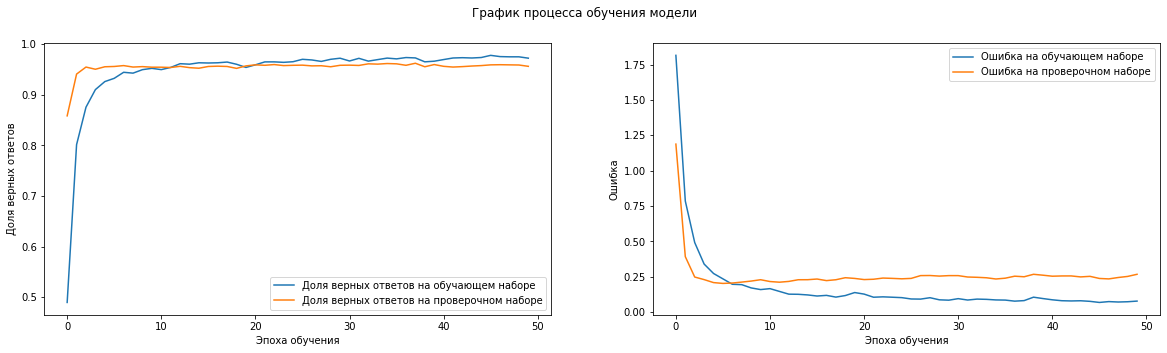

108/108 [==============================] - 0s 2ms/step


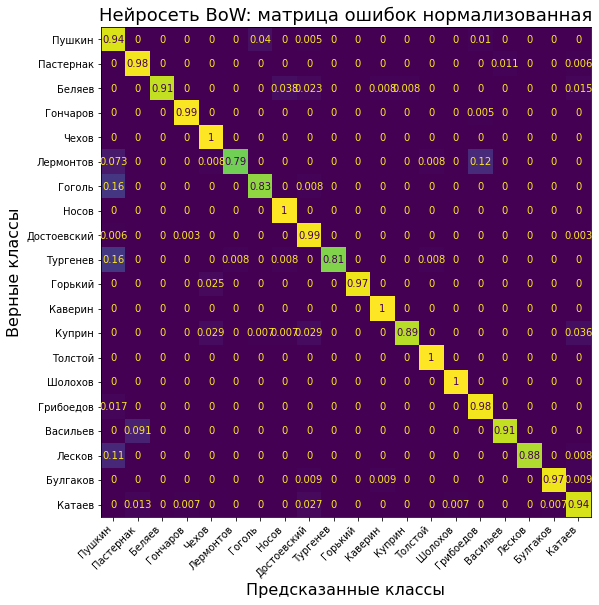

----------------------------------------------------------------------------------------------------
Нейросеть: BoW
Класс: Пушкин                94% сеть отнесла к классу Пушкин               - ВЕРНО :-)
Класс: Пастернак             98% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Беляев                91% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Гончаров             100% сеть отнесла к классу Гончаров             - ВЕРНО :-)
Класс: Чехов                100% сеть отнесла к классу Чехов                - ВЕРНО :-)
Класс: Лермонтов             79% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Гоголь                84% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Носов                100% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Достоевский           99% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Тургенев              81% сеть отнесла к классу Тургенев             - ВЕРНО :-)
Клас

In [47]:
# Создание последовательной модели нейросети
model_text_bow_softmax = Sequential()                                    
model_text_bow_softmax.add(BatchNormalization(input_dim=maxWordsCount))  
model_text_bow_softmax.add(Dense(100,  activation="relu"))                
model_text_bow_softmax.add(Dropout(0.75))                                 
model_text_bow_softmax.add(Dense(40, activation="relu"))                 
model_text_bow_softmax.add(BatchNormalization())
model_text_bow_softmax.add(Dense(CLASS_COUNT, activation='sigmoid'))

# Входные данные подаются в виде векторов bag of words
compile_train_eval_model(model_text_bow_softmax,
                         x_train_01, y_train,
                         x_test_01, y_test,
                         class_labels=CLASS_LIST,
                         epochs=50,
                         batch_size=64,
                         title='BoW')

**02) Embedding модель**

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1000, 70)          700000    
                                                                 
 batch_normalization_78 (Bat  (None, 1000, 70)         280       
 chNormalization)                                                
                                                                 
 dense_125 (Dense)           (None, 1000, 25)          1775      
                                                                 
 dropout_50 (Dropout)        (None, 1000, 25)          0         
                                                                 
 batch_normalization_79 (Bat  (None, 1000, 25)         100       
 chNormalization)                                                
                                                                 
 flatten_6 (Flatten)         (None, 25000)           

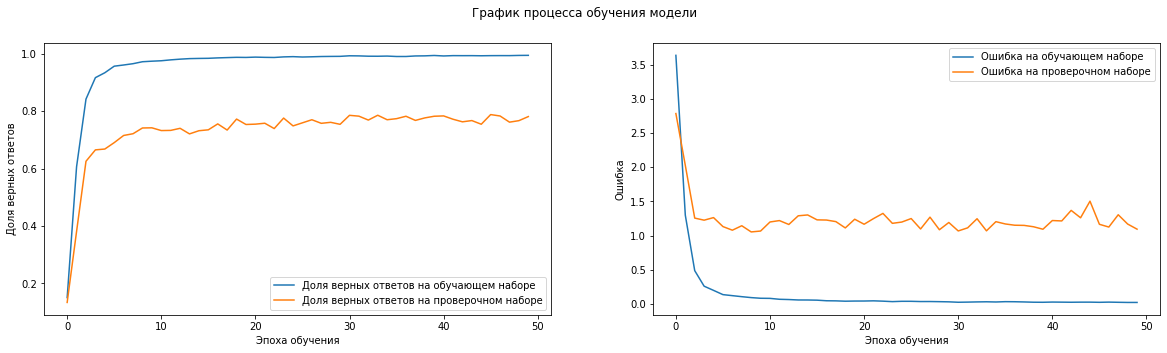

108/108 [==============================] - 0s 2ms/step


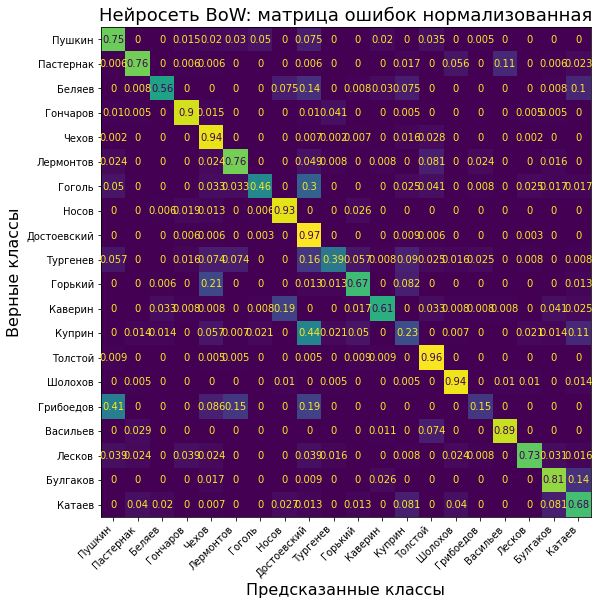

----------------------------------------------------------------------------------------------------
Нейросеть: BoW
Класс: Пушкин                75% сеть отнесла к классу Пушкин               - ВЕРНО :-)
Класс: Пастернак             76% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Беляев                56% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Гончаров              90% сеть отнесла к классу Гончаров             - ВЕРНО :-)
Класс: Чехов                 94% сеть отнесла к классу Чехов                - ВЕРНО :-)
Класс: Лермонтов             76% сеть отнесла к классу Лермонтов            - ВЕРНО :-)
Класс: Гоголь                46% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Носов                 93% сеть отнесла к классу Носов                - ВЕРНО :-)
Класс: Достоевский           97% сеть отнесла к классу Достоевский          - ВЕРНО :-)
Класс: Тургенев              38% сеть отнесла к классу Тургенев             - ВЕРНО :-)
Клас

In [68]:
model_Emb = Sequential()                                               
model_Emb.add(Embedding(maxWordsCount, 70, input_length=sample_len))   
model_Emb.add(BatchNormalization())                                    
model_Emb.add(Dense(25))                                               
model_Emb.add(Dropout(0.75))                                            
model_Emb.add(BatchNormalization())                                    
model_Emb.add(Flatten())                                               
model_Emb.add(Dense(CLASS_COUNT, activation='sigmoid'))                         

compile_train_eval_model(model_Emb,
                         x_train, y_train,
                         x_test, y_test,
                         class_labels=CLASS_LIST,
                         optimizer='rmsprop',
                         epochs=50,
                         batch_size=64,
                         title='BoW')